In [2]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [3]:
# Filtering India data

df_India = df[df['job_country'] == 'India']

In [4]:
# Exploding the job skills

df_skills = df_India.explode('job_skills')

df_skills[['job_title', 'job_skills']]

,job_title,job_skills
16,Big Data Engineer,powershell
16,Big Data Engineer,python
16,Big Data Engineer,sql
16,Big Data Engineer,mysql
16,Big Data Engineer,sql server
...,...,...
785716,Application Support Analyst,c#
785716,Application Support Analyst,sql
785718,Senior Performance QA Analyst,None
785740,AWS System Analyst,aws


In [5]:
# Group by job_skills and job_title_short and count the number of occurrences
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()

# Name the count column as count
df_skills_count = df_skills_count.reset_index(name='skill_count')

# Sort the values by skill_count in descending order
df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

df_skills_count

,job_skills,job_title_short,skill_count
1374,sql,Data Engineer,12993
1088,python,Data Engineer,11568
1089,python,Data Scientist,9248
1327,spark,Data Engineer,7157
103,aws,Data Engineer,6993
...,...,...,...
389,esquisse,Data Scientist,1
887,node.js,Senior Data Analyst,1
753,matlab,Cloud Engineer,1
411,fastapi,Cloud Engineer,1


In [6]:
# Create list for top 3 roles

job_titles = df_skills_count['job_title_short'].unique().tolist()

job_titles = sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

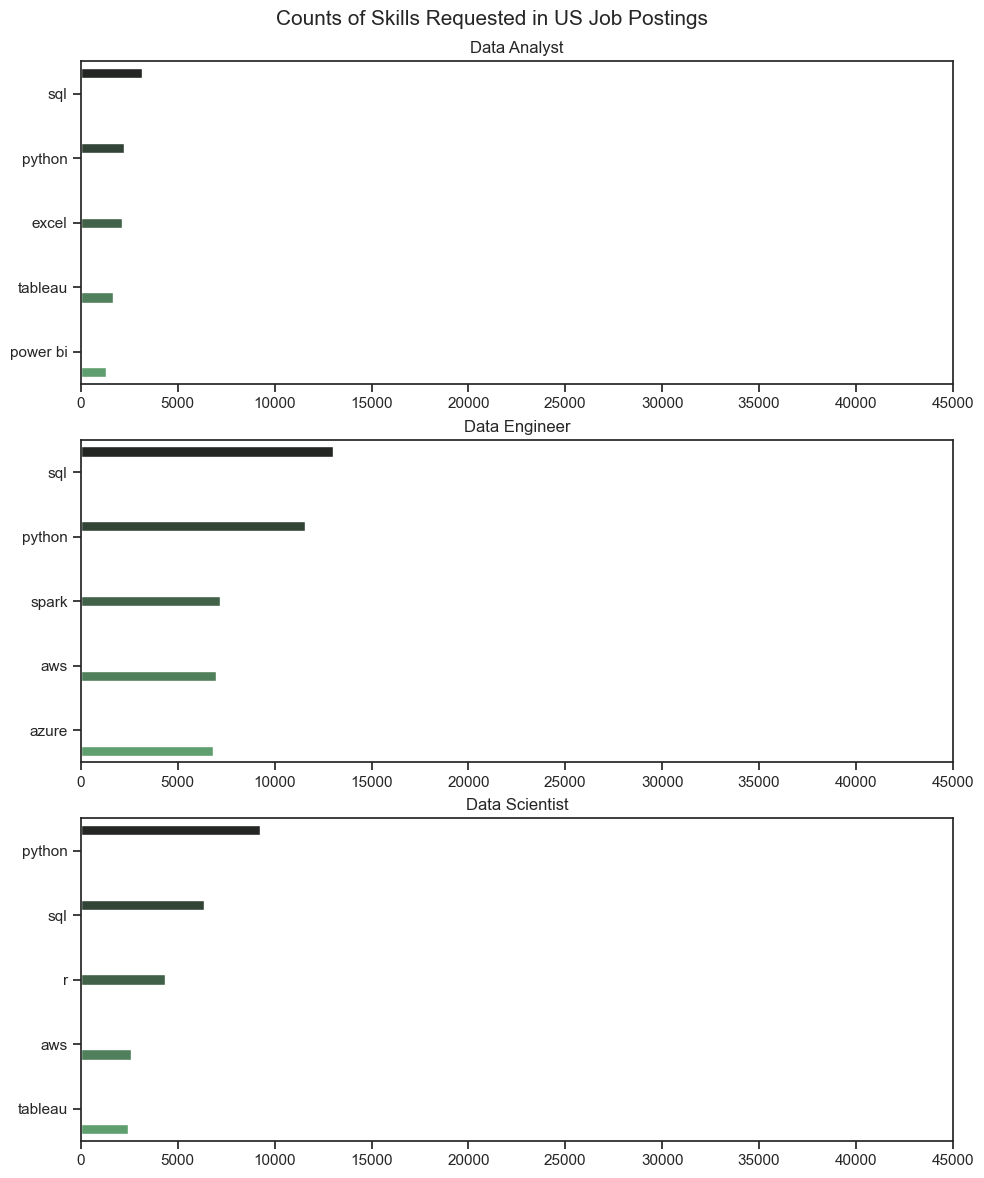

In [9]:
# Creates a stacked horizontal bar chart for the top 5 skills for Top 3 roles, displaying the frequency of each skill.

fig, ax = plt.subplots(len(job_titles), 1, figsize=(10, len(job_titles) * 4))

sns.set_theme(style='ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)[::-1]
    sns.barplot(data=df_plot, x='skill_count', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:g_r')
    ax[i].set_title(job_title)
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 45000) # make the scales the same

fig.suptitle('Counts of Skills Requested in US Job Postings', fontsize=15)
fig.tight_layout(h_pad=0.5) # fix the overlap
plt.show()

In [10]:
# Use original df to get the count of job titles
df_job_title_count = df_India['job_title_short'].value_counts().reset_index(name='jobs_total')

df_job_title_count

,job_title_short,jobs_total
0,Data Engineer,19062
1,Data Scientist,13279
2,Data Analyst,6121
3,Senior Data Engineer,4353
4,Senior Data Scientist,2486
5,Business Analyst,1887
6,Software Engineer,1795
7,Senior Data Analyst,1083
8,Machine Learning Engineer,671
9,Cloud Engineer,351


In [11]:
df_skills_perc = pd.merge(df_skills_count, df_job_title_count, on='job_title_short', how='left')

df_skills_perc['skill_percent'] = (df_skills_perc['skill_count'] / df_skills_perc['jobs_total']) * 100

df_skills_perc

,job_skills,job_title_short,skill_count,jobs_total,skill_percent
0,sql,Data Engineer,12993,19062,68.161788
1,python,Data Engineer,11568,19062,60.686182
2,python,Data Scientist,9248,13279,69.643798
3,spark,Data Engineer,7157,19062,37.545903
4,aws,Data Engineer,6993,19062,36.685552
...,...,...,...,...,...
1684,esquisse,Data Scientist,1,13279,0.007531
1685,node.js,Senior Data Analyst,1,1083,0.092336
1686,matlab,Cloud Engineer,1,351,0.284900
1687,fastapi,Cloud Engineer,1,351,0.284900


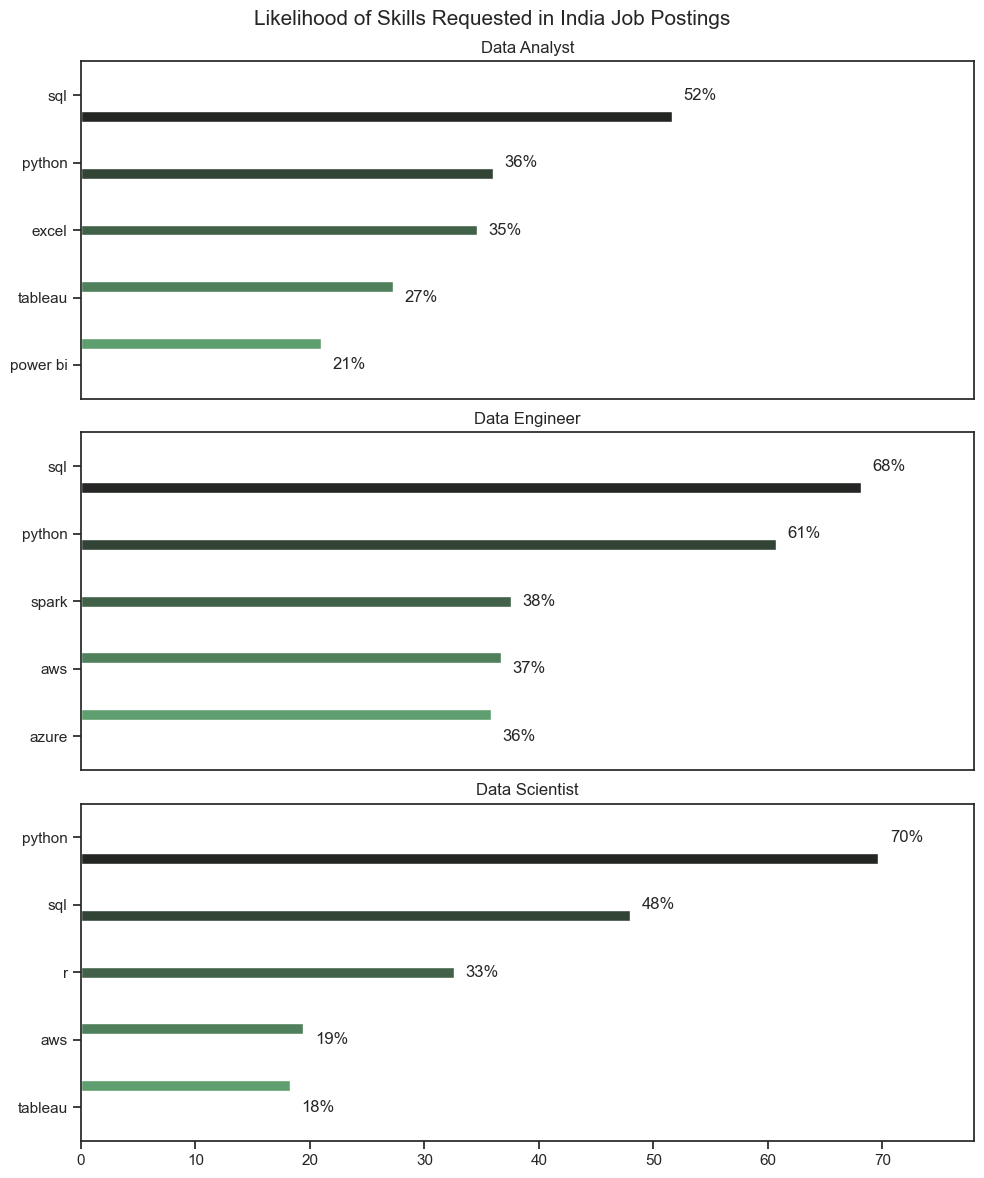

In [14]:
fig, ax = plt.subplots(len(job_titles), 1, figsize=(10, len(job_titles)*4))


for i, job_title in enumerate(job_titles):
    df_plot = df_skills_perc[df_skills_perc['job_title_short'] == job_title].head(5)
    sns.barplot(data=df_plot, x='skill_percent', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:g_r')
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 78)
    # remove the x-axis tick labels for better readability
    if i != len(job_titles) - 1:
        ax[i].set_xticks([])

    # label the percentage on the bars
    for n, v in enumerate(df_plot['skill_percent']):
        ax[i].text(v + 1, n, f'{v:.0f}%', va='center')

fig.suptitle('Likelihood of Skills Requested in India Job Postings', fontsize=15)
fig.tight_layout(h_pad=.8)
plt.show()